In [54]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import gym

In [40]:
# Model Hyperparameters

dataset_path = './datasets'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

batch_size = 1000
x_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

Using device: cuda


In [41]:
mnist_transform = transforms.Compose([transforms.ToTensor(),])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=False)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)                     
        return mean, log_var
    

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
           
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var
    
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [43]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

In [44]:
print("Start training VAE...")
model.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  244.61689830508473
	Epoch 2 complete! 	Average Loss:  197.37693273305084
	Epoch 3 complete! 	Average Loss:  184.68927595338982
	Epoch 4 complete! 	Average Loss:  166.3844163135593
	Epoch 5 complete! 	Average Loss:  153.30754925847458
	Epoch 6 complete! 	Average Loss:  142.92482388771185
	Epoch 7 complete! 	Average Loss:  135.90986811440678
	Epoch 8 complete! 	Average Loss:  130.38238824152543
	Epoch 9 complete! 	Average Loss:  126.02160037076271
	Epoch 10 complete! 	Average Loss:  122.80276125529662
	Epoch 11 complete! 	Average Loss:  120.37260911016949
	Epoch 12 complete! 	Average Loss:  118.2991860434322
	Epoch 13 complete! 	Average Loss:  116.72105733580509
	Epoch 14 complete! 	Average Loss:  115.33005256885593
	Epoch 15 complete! 	Average Loss:  114.18124351165254
	Epoch 16 complete! 	Average Loss:  113.10879157838983
	Epoch 17 complete! 	Average Loss:  112.16747788665255
	Epoch 18 complete! 	Average Loss:  111.32696477754237

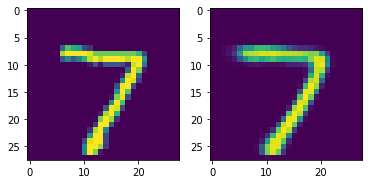

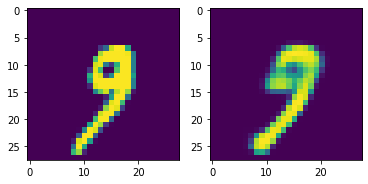

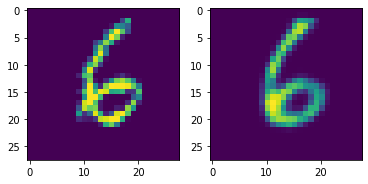

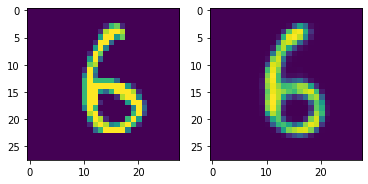

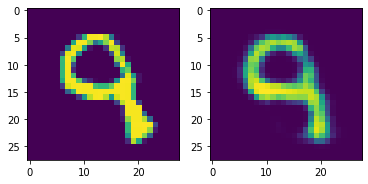

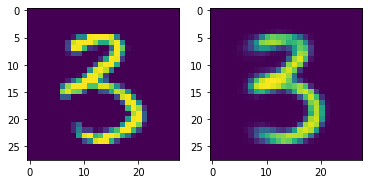

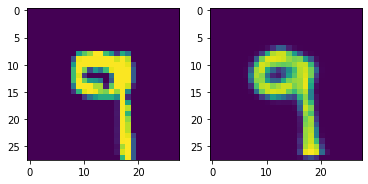

In [53]:
def show_image(x, x_hat, idx):
    x = x.view(batch_size, 28, 28)
    x_hat = x_hat.view(batch_size,28,28)
    fig,ax = plt.subplots(ncols=2)
    ax[0].imshow(x[idx].cpu().numpy())
    ax[1].imshow(x_hat[idx].cpu().numpy())
    

model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_hat, _, _ = model(x)
        show_image(x, x_hat, idx=0)
        if batch_idx>5:
            break